# Predicting Bike Rental Count

-  The objective of this Case is Predication of bike rental count on daily based on the environmental and seasonal settings

In [146]:
# loading the required libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from fancyimpute import KNN
from scipy.stats import chi2_contingency

In [3]:
# set the working directory
os.chdir('C:/Users/admin/Documents/Python Files')
os.getcwd()

'C:\\Users\\admin\\Documents\\Python Files'

The details of data attributes in the dataset are as follows:
-  instant: Record index
-  dteday: Date
-  season: Season (1:springer, 2:summer, 3:fall, 4:winter)
-  yr: Year (0: 2011, 1:2012)
-  mnth: Month (1 to 12)
-  holiday: weather day is holiday or not (extracted fromHoliday Schedule)
-  weekday: Day of the week
-  workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
-  weathersit: (extracted fromFreemeteo)
    -   1: Clear, Few clouds, Partly cloudy, Partly cloudy
    -   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    -   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scatteredclouds
    -   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
-  temp: Normalized temperature in Celsius. The values are derived via(t-t_min)/(t_max-t_min),t_min=-8, t_max=+39 (only in hourly scale)
-  atemp: Normalized feeling temperature in Celsius. The values are derived via(t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
-  hum: Normalized humidity. The values are divided to 100 (max)
-  windspeed: Normalized wind speed. The values are divided to 67 (max)
-  casual: count of casual users
-  registered: count of registered users
-  cnt: count of total rental bikes including both casual and registered

In [194]:
# Importing data
df = pd.read_csv('day.csv',index_col='dteday',parse_dates=True,infer_datetime_format=True,dayfirst=True)
# Dropping the 1st column i.e. 'instant' Coz it is seems statisticaly insignificant
df=df.drop('instant',axis=1)
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [7]:
df.describe(),df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 14 columns):
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(10)
memory usage: 85.7 KB


(           season          yr        mnth     holiday     weekday  workingday  \
 count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
 mean     2.496580    0.500684    6.519836    0.028728    2.997264    0.683995   
 std      1.110807    0.500342    3.451913    0.167155    2.004787    0.465233   
 min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
 25%      2.000000    0.000000    4.000000    0.000000    1.000000    0.000000   
 50%      3.000000    1.000000    7.000000    0.000000    3.000000    1.000000   
 75%      3.000000    1.000000   10.000000    0.000000    5.000000    1.000000   
 max      4.000000    1.000000   12.000000    1.000000    6.000000    1.000000   
 
        weathersit        temp       atemp         hum   windspeed  \
 count  731.000000  731.000000  731.000000  731.000000  731.000000   
 mean     1.395349    0.495385    0.474354    0.627894    0.190486   
 std      0.544894    0.183051    0.162961    0.14

-  We have used dteday as index and converted it into DatetimeIndex 

In [5]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Graphical EDA - Data Visualization 

In [11]:
# setting up the sns for plots
sns.set(style='darkgrid',palette='Set1')

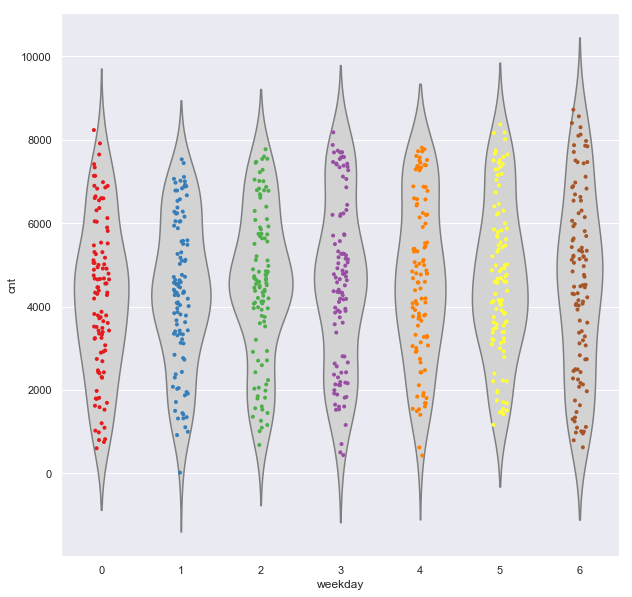

In [7]:
plt.figure(figsize=(10,10))
_ = sns.violinplot(x='weekday',y='cnt',data=df,inner=None,color='lightgray')
_ = sns.stripplot(x='weekday',y='cnt',data=df,size=4,jitter=True)
plt.title('')
plt.show()

-  We will plot some Bee Swarmplots coz unlike histogram there is no binnig bias involved

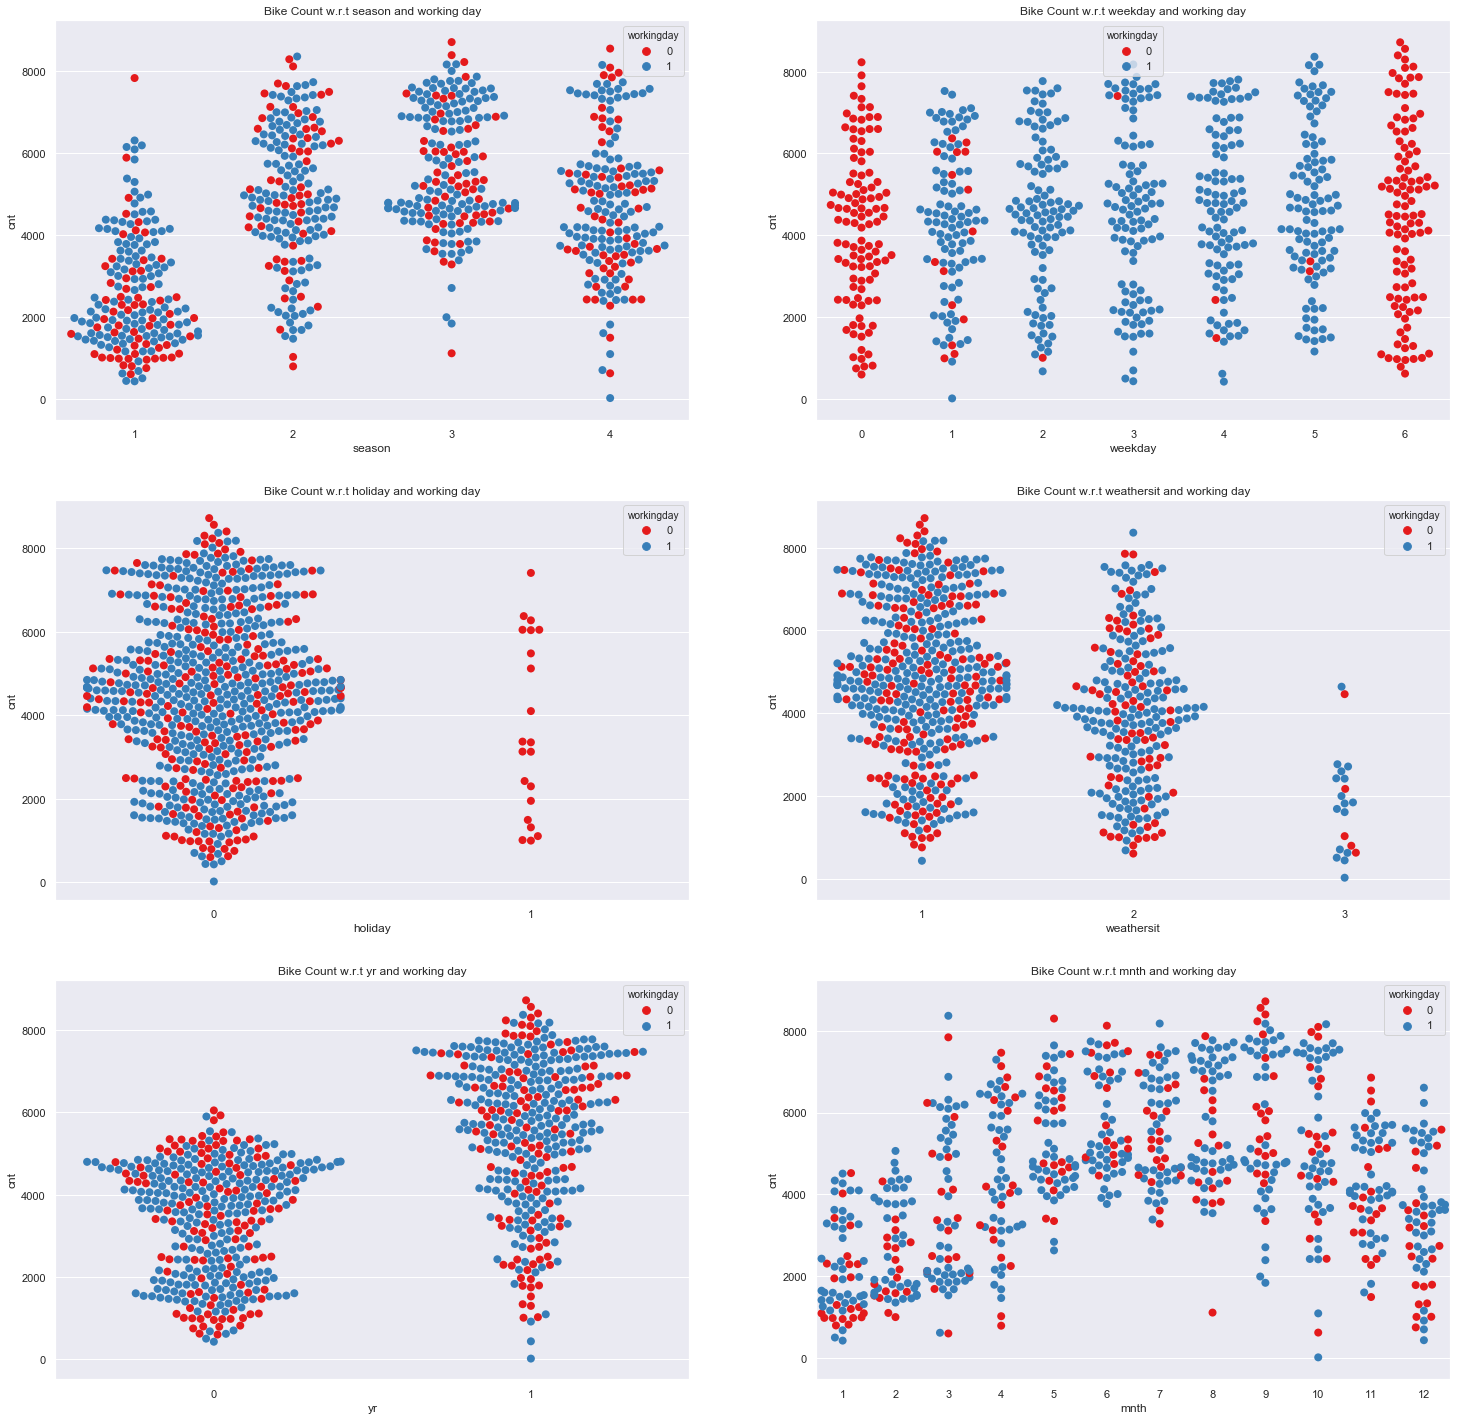

In [8]:
plt.figure(figsize=(25,25))
plt.subplot(321)
_ = sns.swarmplot(x='season',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t season and working day')
plt.subplot(322)
_ = sns.swarmplot(x='weekday',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t weekday and working day')
plt.subplot(323)
_ = sns.swarmplot(x='holiday',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t holiday and working day')
plt.subplot(324)
_ = sns.swarmplot(x='weathersit',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t weathersit and working day')
plt.subplot(325)
_ = sns.swarmplot(x='yr',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t yr and working day')
plt.subplot(326)
_ = sns.swarmplot(x='mnth',y='cnt',data=df,hue='workingday',size=8)
plt.title('Bike Count w.r.t mnth and working day')
plt.show()

In [9]:
temp = df['temp']
temp=temp['2011']
atemp = df['atemp']
atemp = atemp['2011']
hum = df['hum']
hum = hum['2011']
windspeed = df['windspeed']
windspeed = windspeed['2011']
temp_index = temp.index[::30]
labels = temp_index.strftime('%b %d')
labels

Index(['Jan 01', 'Jan 31', 'Mar 02', 'Apr 01', 'May 01', 'May 31', 'Jun 30',
       'Jul 30', 'Aug 29', 'Sep 28', 'Oct 28', 'Nov 27', 'Dec 27'],
      dtype='object')

-  Now we will do some Time Series Analysis

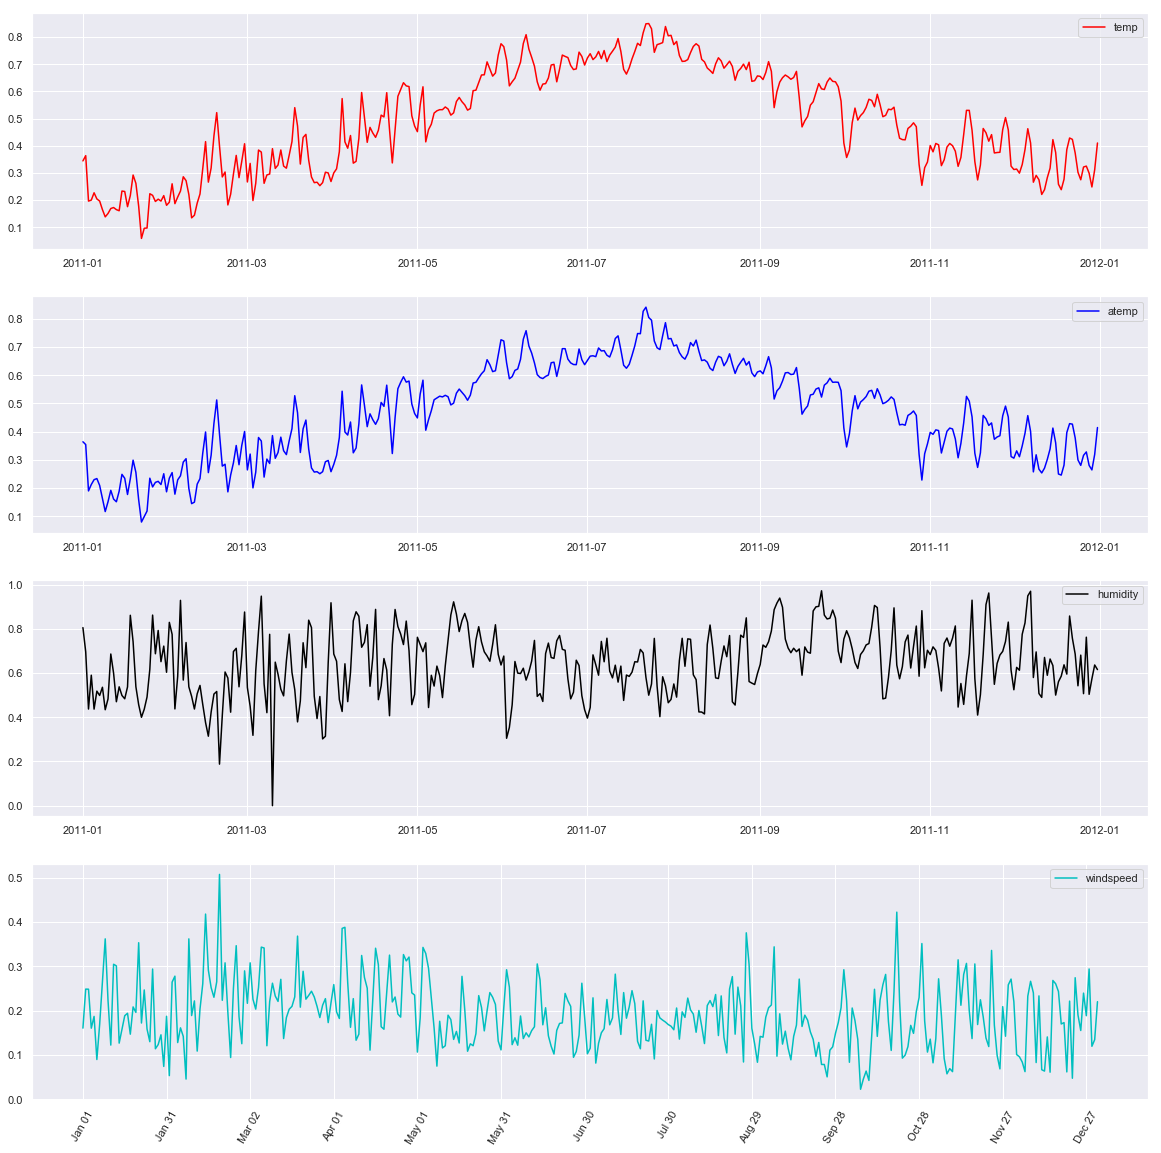

In [10]:
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(temp,color = 'r',label = 'temp')
plt.legend(loc = 1)
plt.subplot(412)
plt.plot(atemp,color = 'b',label = 'atemp')
plt.legend(loc = 1)
plt.subplot(413)
plt.plot(hum,color = 'k',label = 'humidity')
plt.legend(loc = 1)
plt.subplot(414)
plt.plot(windspeed,color = 'c',label = 'windspeed')
plt.xticks(temp_index,labels,rotation=60)
plt.legend(loc = 1)
plt.show()

-  Now we will see at some Jointplots.
-  They are used for Bivariate Analysis.
-  Here we have plotted Scatter plot with Regression line between 2 variables along with separate Bar plots of both variables.
-  Also we have annotated pearson correlation coefficient and p value.

C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


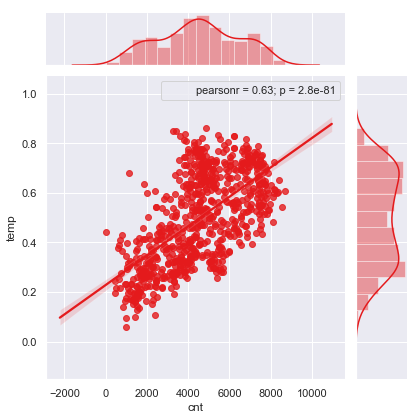

In [120]:
_ = sns.jointplot(x='cnt',y='temp',data=df,kind = 'reg')
_.annotate(stats.pearsonr)
plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


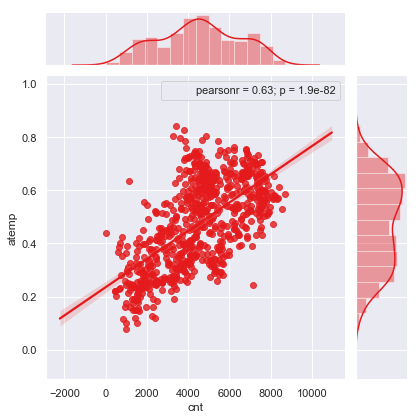

In [88]:
_ = sns.jointplot(x='cnt',y='atemp',data=df,kind = 'reg')
_.annotate(stats.pearsonr)
plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


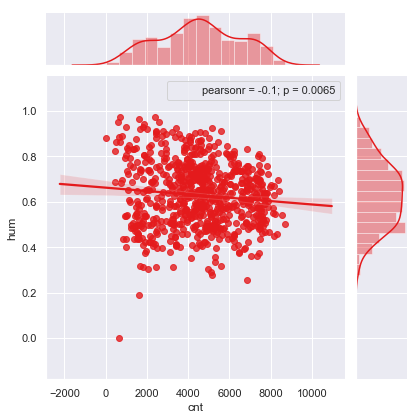

In [14]:
_ = sns.jointplot(x='cnt',y='hum',data=df,kind = 'reg')
_.annotate(stats.pearsonr)
plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


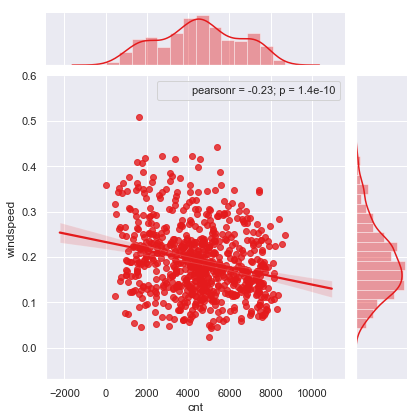

In [15]:
_ = sns.jointplot(x='cnt',y='windspeed',data=df,kind = 'reg')
_.annotate(stats.pearsonr)
plt.show()

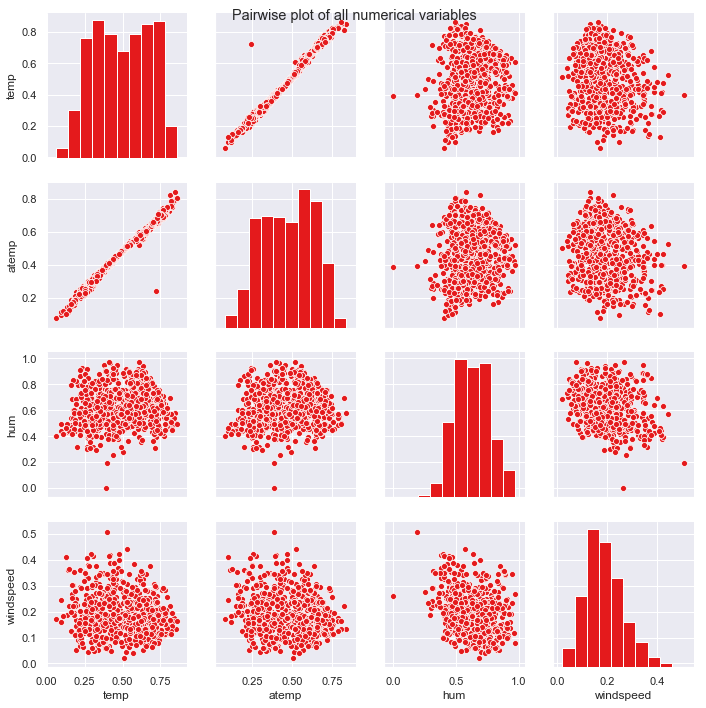

In [119]:
#plt.title('Pairplot for all numerical variables')
_ =sns.pairplot(data=df[num_var],kind='scatter')
_.fig.suptitle('Pairwise plot of all numerical variables')
plt.show()

## EDA - Data type conversion

In [195]:
cat_var=['season','holiday','weekday','workingday','weathersit','yr','mnth']
df[cat_var]=df[cat_var].apply(lambda x: x.astype('category') )
num_var=['temp','atemp','hum','windspeed','cnt']

## Missing Value Analysis 

In [240]:
pd.DataFrame(df.isnull().sum())

,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0
hum,0


In [ ]:
df.info()

## Outlier Analysis using Boxplot

-  Univariate Boxplots

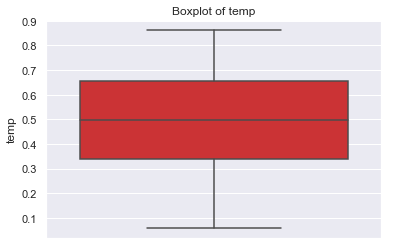

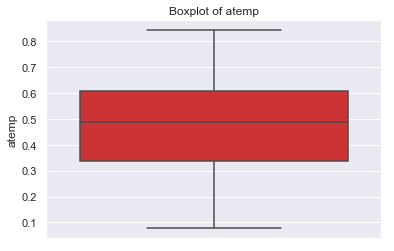

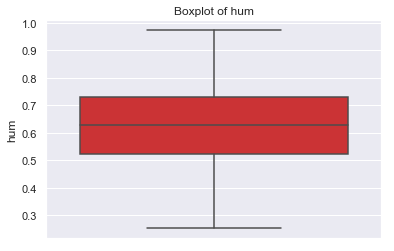

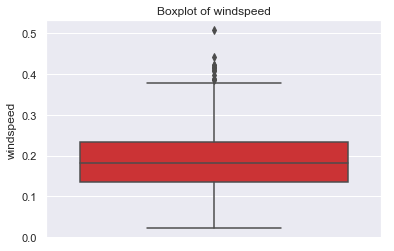

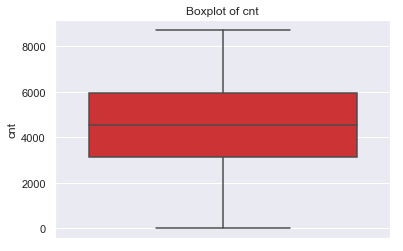

In [67]:
for i in num_var:
    sns.boxplot(y=i,data=df)
    plt.title('Boxplot of '+i)
    plt.show()

-  Bivariate Boxplots

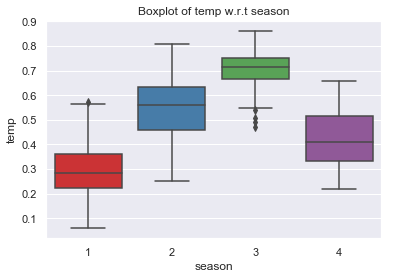

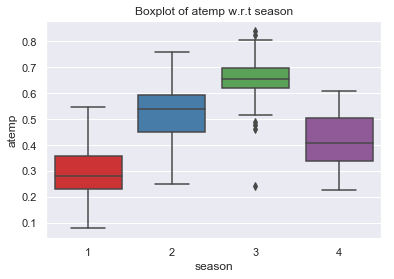

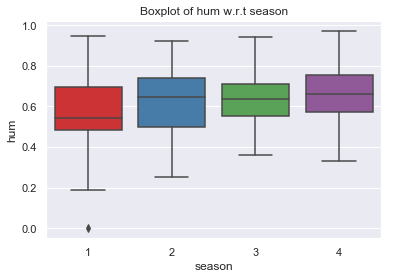

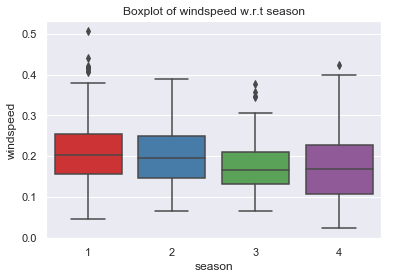

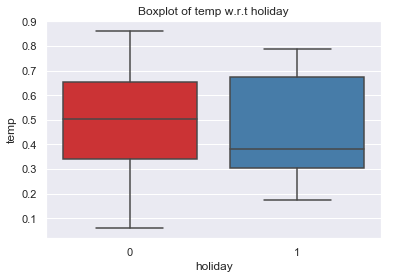

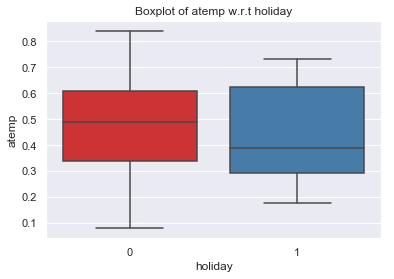

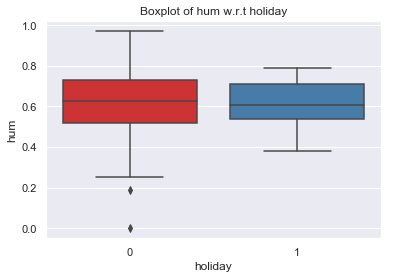

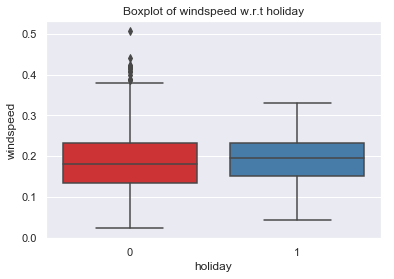

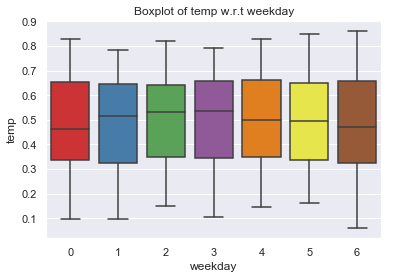

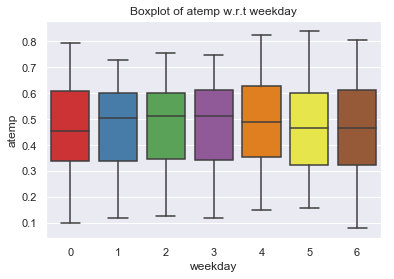

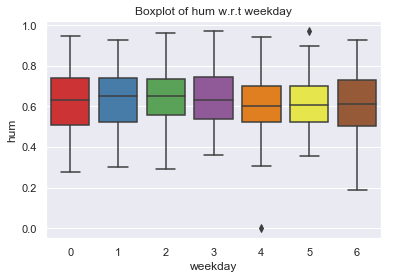

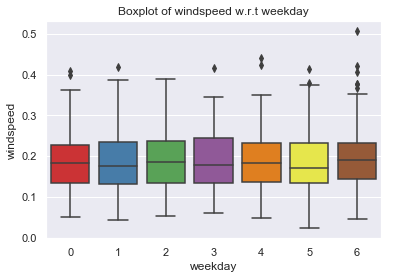

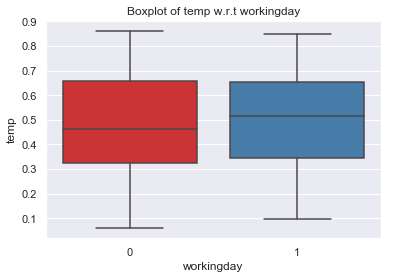

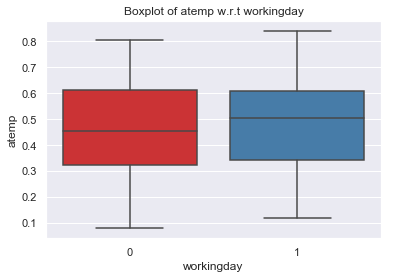

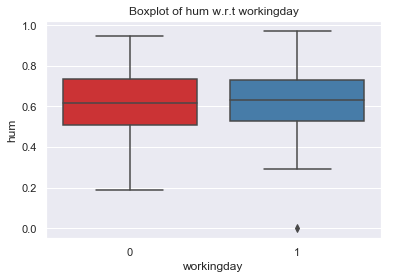

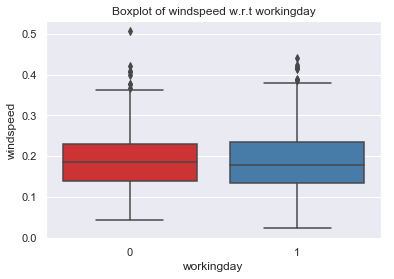

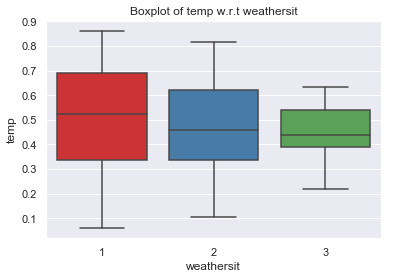

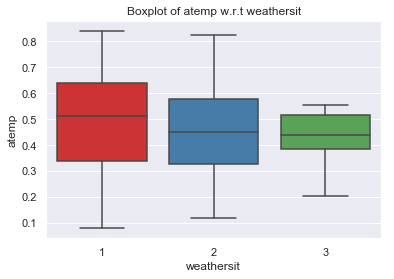

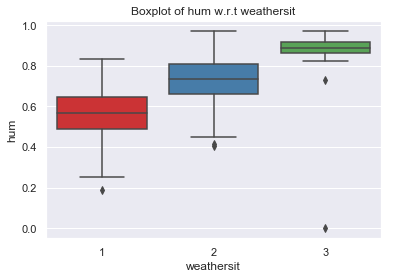

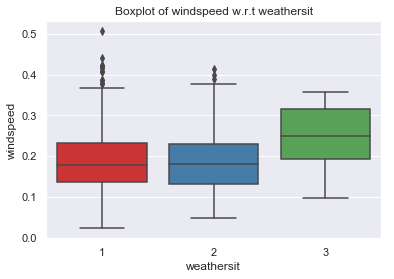

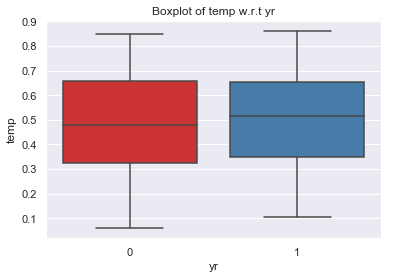

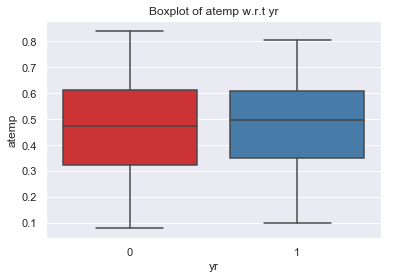

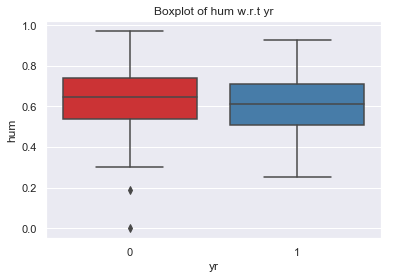

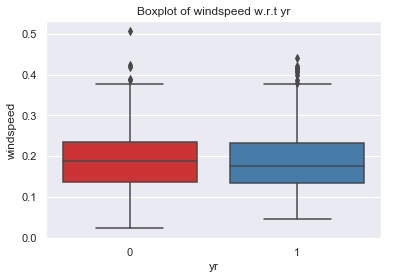

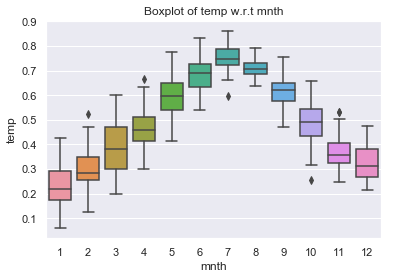

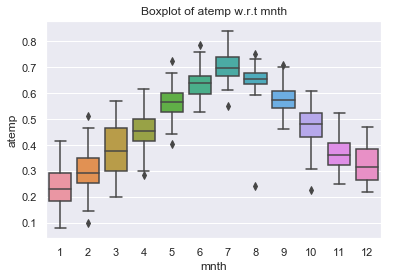

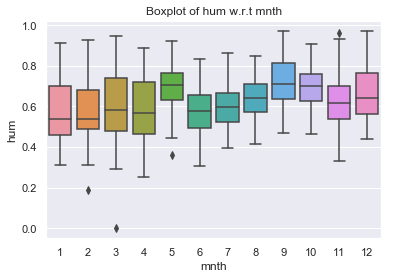

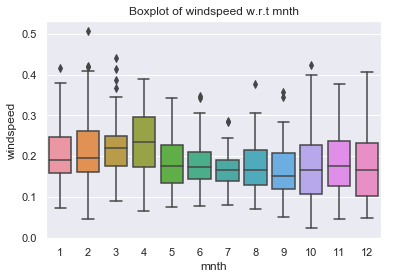

In [14]:
for a in cat_var:
    for b in num_var:
        _ = sns.boxplot(x=a,y=b,data=df)
        plt.title('Boxplot of '+b+' w.r.t '+a)
        plt.show()

## Outlier Treatment
-  As we can see from the above Boxplots only 'hum' and 'windspeed' columns in the dataset has outliers

In [72]:
df.std()

season           1.110807
yr               0.500342
mnth             3.451913
holiday          0.167155
weekday          2.004787
workingday       0.465233
weathersit       0.544894
temp             0.183051
atemp            0.162961
hum              0.142429
windspeed        0.077498
casual         686.622488
registered    1560.256377
cnt           1937.211452
dtype: float64

#### Std Deviation before outlier treatment :
-  standard deviation for 'hum'= 0.142429
-  standard deviation for 'windspeed'= 0.077498

In [196]:
def outlier_treatment(col):
    ''' calculating outlier indices and replacing them with NA  '''
    #Extract quartiles
    q75, q25 = np.percentile(df[col], [75 ,25])
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    #Replace with NA
    df.loc[df[col] < minimum,col] = np.nan
    df.loc[df[col] > maximum,col] = np.nan

In [197]:
outlier_treatment('hum')

In [198]:
df['hum'].isnull().sum()

2

In [199]:
#Imputing with missing values using KNN
df = pd.DataFrame(KNN(k = 3).fit_transform(df), columns = df.columns, index=df.index)

Imputing row 1/731 with 0 missing, elapsed time: 0.167
Imputing row 101/731 with 0 missing, elapsed time: 0.169
Imputing row 201/731 with 0 missing, elapsed time: 0.170
Imputing row 301/731 with 0 missing, elapsed time: 0.171
Imputing row 401/731 with 0 missing, elapsed time: 0.172
Imputing row 501/731 with 0 missing, elapsed time: 0.173
Imputing row 601/731 with 0 missing, elapsed time: 0.173
Imputing row 701/731 with 0 missing, elapsed time: 0.174


In [200]:
outlier_treatment('windspeed')

In [201]:
df['windspeed'].isnull().sum()

13

In [202]:
#Imputing with missing values using KNN
df = pd.DataFrame(KNN(k = 1).fit_transform(df), columns = df.columns, index=df.index)

Imputing row 1/731 with 0 missing, elapsed time: 0.141
Imputing row 101/731 with 0 missing, elapsed time: 0.142
Imputing row 201/731 with 0 missing, elapsed time: 0.142
Imputing row 301/731 with 0 missing, elapsed time: 0.143
Imputing row 401/731 with 0 missing, elapsed time: 0.143
Imputing row 501/731 with 0 missing, elapsed time: 0.144
Imputing row 601/731 with 0 missing, elapsed time: 0.144
Imputing row 701/731 with 0 missing, elapsed time: 0.144


In [211]:
# #Impute with mean
# df['hum'] = df['hum'].fillna(df['hum'].median())
# #Impute with median
# df['windspeed'] = df['windspeed'].fillna(df['windspeed'].median())

In [162]:
df.std()

season           1.110807
yr               0.500342
mnth             3.451913
holiday          0.167155
weekday          2.004787
workingday       0.465233
weathersit       0.544894
temp             0.183051
atemp            0.162961
hum              0.140021
windspeed        0.071707
casual         686.622488
registered    1560.256377
cnt           1937.211452
dtype: float64

#### Std Deviation after outlier treatment :
-  standard deviation for 'hum'= 0.140021
-  standard deviation for 'windspeed'= 0.071707

In [250]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,
2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0
2011-01-02,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0
2011-01-03,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0
2011-01-04,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0
2011-01-05,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0


## Feature Selection

### Correlation Analysis for Numerical Variables/Features

-  We will plot a Heatmap of correlation whereas, co measures how strongly 2 quantities are related to each other.
-  We go for correlation to avoid redundant information in our model development.

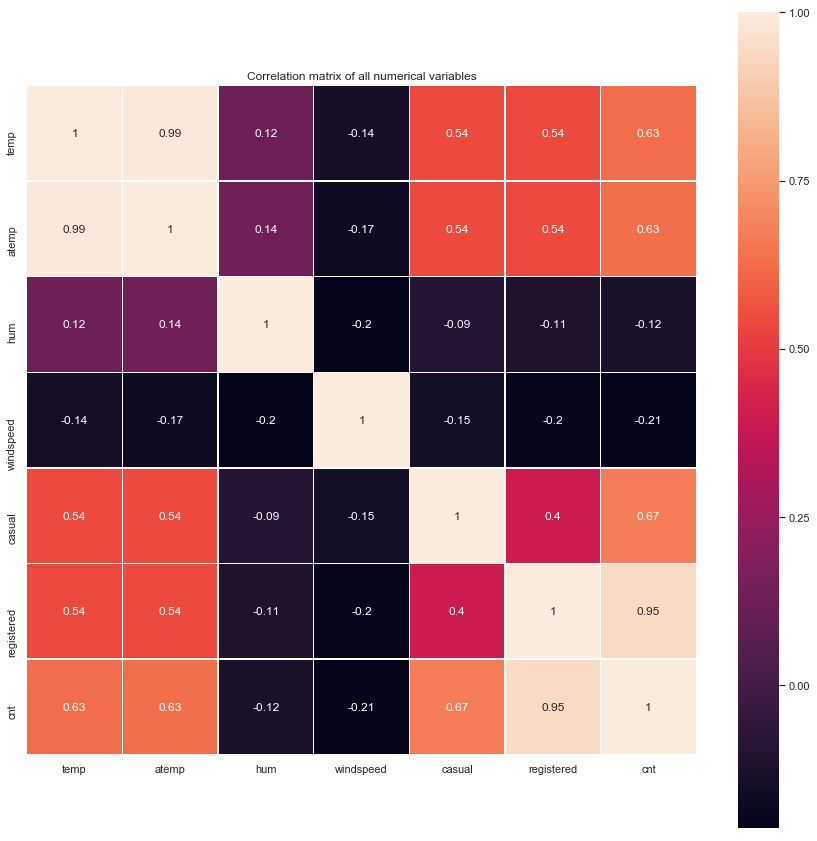

In [143]:
# heatmap using correlation matrix
plt.figure(figsize=(15,15))
_ = sns.heatmap(df[['temp','atemp','hum','windspeed','casual', 'registered','cnt']].corr(),linewidths=0.5,linecolor='w',square=True,annot=True)
plt.title('Correlation matrix of all numerical variables')
plt.show()

-  'temp' and 'atemp' are very highly correlated with each other.
-  similarly 'registered' and 'cnt' are highly correlated with each other.
-  we will drop 'casual' and 'registered' columns frm our dataframe as their addition is included in 'cnt' column.

### Chi-square test of Independence for Categorical Variables/Features

In [149]:
#loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[i], df[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other")
            else:
                print(i,"and",j,"are independent on each other")

season and holiday are independent on each other
season and weekday are independent on each other
season and workingday are independent on each other
season and weathersit are dependent on each other
season and yr are independent on each other
season and mnth are dependent on each other
holiday and season are independent on each other
holiday and weekday are dependent on each other
holiday and workingday are dependent on each other
holiday and weathersit are independent on each other
holiday and yr are independent on each other
holiday and mnth are independent on each other
weekday and season are independent on each other
weekday and holiday are dependent on each other
weekday and workingday are dependent on each other
weekday and weathersit are independent on each other
weekday and yr are independent on each other
weekday and mnth are independent on each other
workingday and season are independent on each other
workingday and holiday are dependent on each other
workingday and weekday 

-  If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
-  And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent. 

## Feature Scaling

-  Let us check variance for each column in dataset before Normalisation

In [124]:
df.var()

season        1.233892e+00
yr            2.503420e-01
mnth          1.191570e+01
holiday       2.794071e-02
weekday       4.019171e+00
workingday    2.164421e-01
weathersit    2.969098e-01
temp          3.350767e-02
atemp         2.655635e-02
hum           1.960583e-02
windspeed     5.141876e-03
casual        4.714504e+05
registered    2.434400e+06
cnt           3.752788e+06
dtype: float64

C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Probability Plot')]

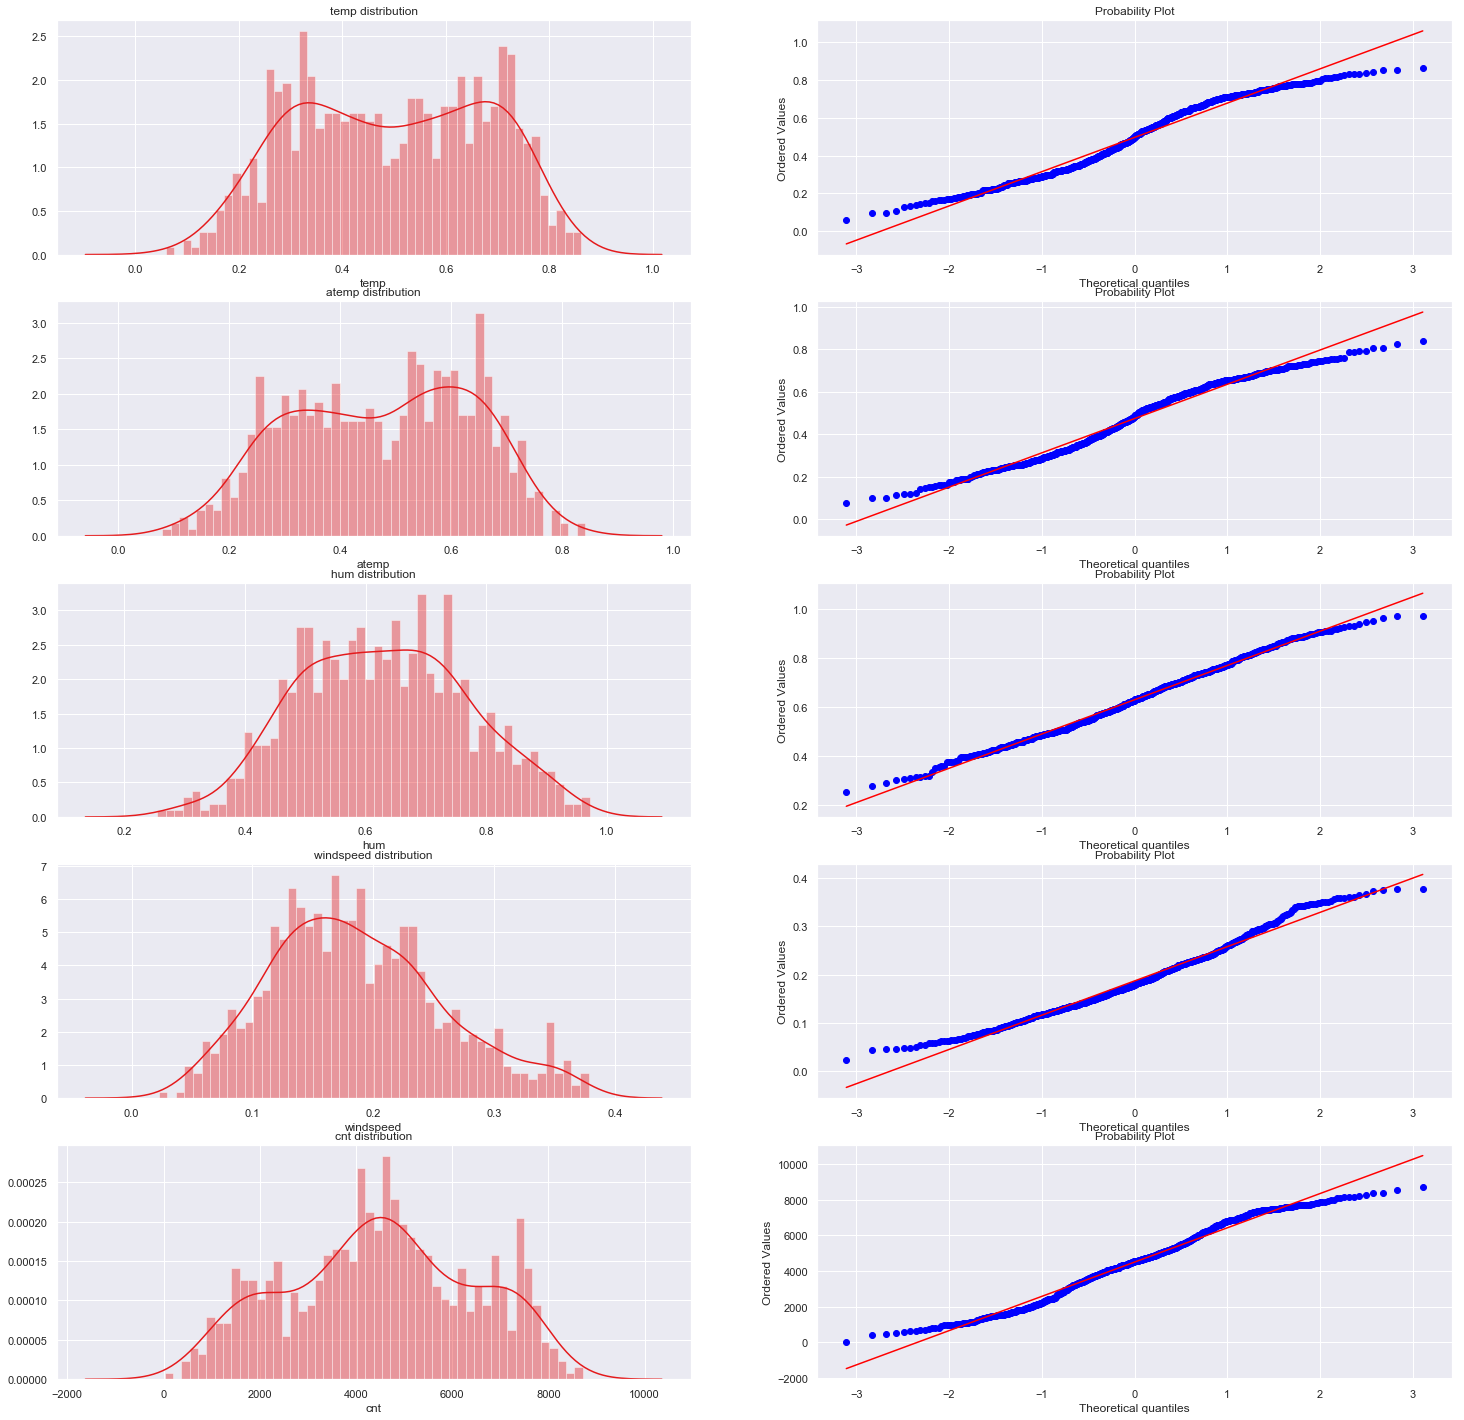

In [137]:
fig,ax = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(25, 25)
sns.distplot(df['temp'],bins =50,ax = ax[0][0])
ax[0][0].set(title="temp distribution")
_ = stats.probplot(df['temp'], dist='norm', fit=True,plot=ax[0][1])
ax[0][1].set(title="Probability Plot")
sns.distplot(df['atemp'],bins =50,ax = ax[1][0])
ax[1][0].set(title="atemp distribution")
_ = stats.probplot(df['atemp'], dist='norm', fit=True,plot=ax[1][1])
ax[1][1].set(title="Probability Plot")
sns.distplot(df['hum'],bins =50,ax = ax[2][0])
ax[2][0].set(title="hum distribution")
_ = stats.probplot(df['hum'], dist='norm', fit=True,plot=ax[2][1])
ax[2][1].set(title="Probability Plot")
sns.distplot(df['windspeed'],bins =50,ax = ax[3][0])
ax[3][0].set(title="windspeed distribution")
_ = stats.probplot(df['windspeed'], dist='norm', fit=True,plot=ax[3][1])
ax[3][1].set(title="Probability Plot")
sns.distplot(df['cnt'],bins =50,ax = ax[4][0])
ax[4][0].set(title="cnt distribution")
_ = stats.probplot(df['cnt'], dist='norm', fit=True,plot=ax[4][1])
ax[4][1].set(title="Probability Plot")

In [203]:
#Normalisation
for i in num_var:
    print(i)
    df[i] = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))

temp
atemp
hum
windspeed
cnt


-  Plots after Normalisation

C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Probability Plot')]

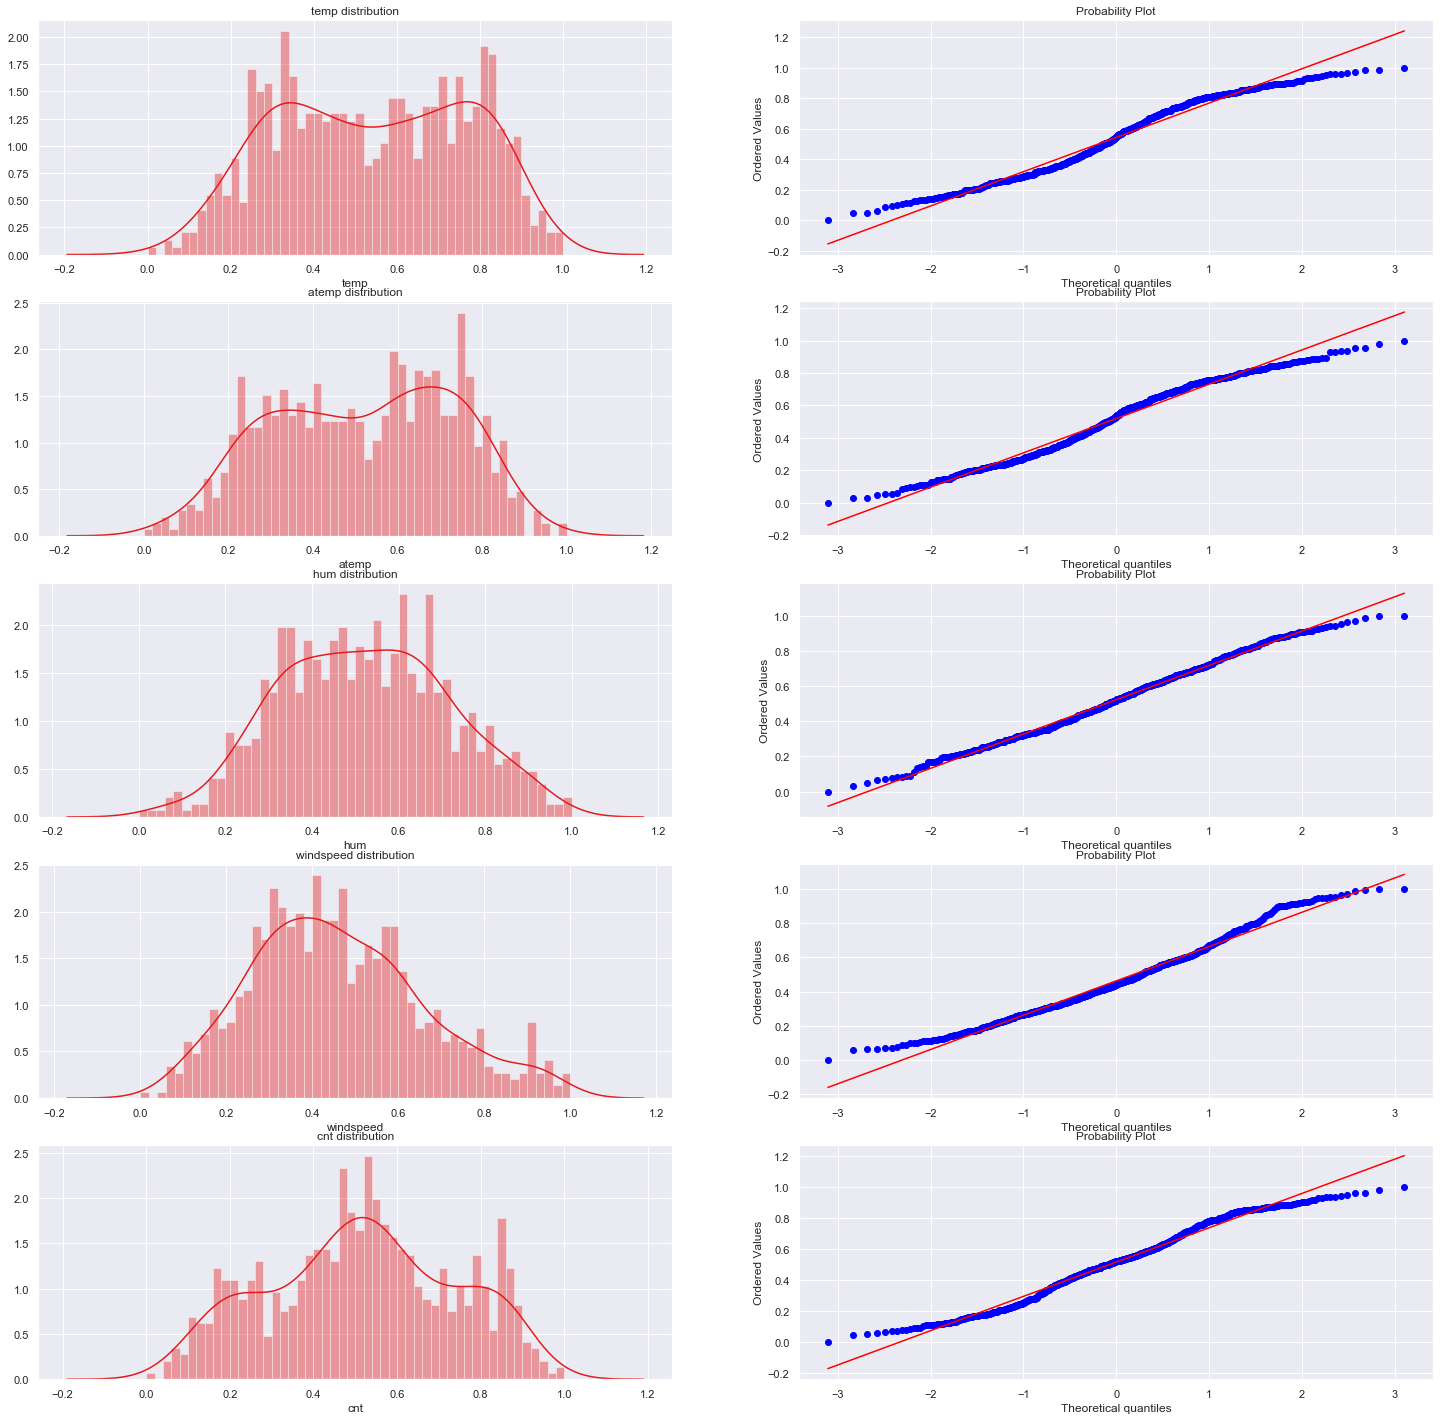

In [164]:
fig,ax = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(25, 25)
sns.distplot(df['temp'],bins =50,ax = ax[0][0])
ax[0][0].set(title="temp distribution")
_ = stats.probplot(df['temp'], dist='norm', fit=True,plot=ax[0][1])
ax[0][1].set(title="Probability Plot")
sns.distplot(df['atemp'],bins =50,ax = ax[1][0])
ax[1][0].set(title="atemp distribution")
_ = stats.probplot(df['atemp'], dist='norm', fit=True,plot=ax[1][1])
ax[1][1].set(title="Probability Plot")
sns.distplot(df['hum'],bins =50,ax = ax[2][0])
ax[2][0].set(title="hum distribution")
_ = stats.probplot(df['hum'], dist='norm', fit=True,plot=ax[2][1])
ax[2][1].set(title="Probability Plot")
sns.distplot(df['windspeed'],bins =50,ax = ax[3][0])
ax[3][0].set(title="windspeed distribution")
_ = stats.probplot(df['windspeed'], dist='norm', fit=True,plot=ax[3][1])
ax[3][1].set(title="Probability Plot")
sns.distplot(df['cnt'],bins =50,ax = ax[4][0])
ax[4][0].set(title="cnt distribution")
_ = stats.probplot(df['cnt'], dist='norm', fit=True,plot=ax[4][1])
ax[4][1].set(title="Probability Plot")

-  Let us check variance for each column in dataset after Normalisation

In [165]:
df.var()

season        1.233892e+00
yr            2.503420e-01
mnth          1.191570e+01
holiday       2.794071e-02
weekday       4.019171e+00
workingday    2.164421e-01
weathersit    2.969098e-01
temp          5.202529e-02
atemp         4.575687e-02
hum           3.799562e-02
windspeed     4.063629e-02
casual        4.714504e+05
registered    2.434400e+06
cnt           4.967234e-02
dtype: float64

## Feature Engineering

#### Feature Engineering on numerical Features
-  we know that temp and atemp are both temperature values and are very highly correlated with each other.
-  we will aggregate those 2 columns and derive a new feature.

In [204]:
columns = ['temp','atemp']
df['mean_temp'] = df.apply(lambda row: row[columns].mean(), axis=1)

In [205]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,mean_temp
dteday,,,,,,,,,,,,,,,
2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.355170,0.373517,0.767981,0.388102,331.0,654.0,0.110792,0.364343
2011-01-02,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.379232,0.360541,0.615202,0.635752,131.0,670.0,0.089623,0.369886
2011-01-03,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.171000,0.144830,0.254904,0.635105,120.0,1229.0,0.152669,0.157915
2011-01-04,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.175530,0.174649,0.468123,0.387681,108.0,1454.0,0.177174,0.175090
2011-01-05,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.209120,0.197158,0.254464,0.462471,82.0,1518.0,0.181546,0.203139


-  Now that we have derived a new Column 'mean_temp' we can drop 'temp' and 'atemp'

In [207]:
df = df.drop(['temp','atemp'],axis = 1)

In [208]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,hum,windspeed,casual,registered,cnt,mean_temp
dteday,,,,,,,,,,,,,
2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.767981,0.388102,331.0,654.0,0.110792,0.364343
2011-01-02,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.615202,0.635752,131.0,670.0,0.089623,0.369886
2011-01-03,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.254904,0.635105,120.0,1229.0,0.152669,0.157915
2011-01-04,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.468123,0.387681,108.0,1454.0,0.177174,0.175090
2011-01-05,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.254464,0.462471,82.0,1518.0,0.181546,0.203139


#### Feature Engineering on Categorical Features
-  we will use one-hot encoding techniques on categorical variables - season,mnth,weekday,weathersit.

In [209]:
df.nunique()

season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
hum           595
windspeed     637
casual        606
registered    679
cnt           696
mean_temp     729
dtype: int64

In [210]:
one_hot_var = ['season','mnth','weekday','weathersit']

In [211]:
#Creating dummies for categorical variables
for i in one_hot_var:
    ''' Creating dummies for each variable in one_hot_var and merging dummies dataframe to our original dataframe '''
    temp = pd.get_dummies(df[i], prefix = i)
    df = df.join(temp)

In [212]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'hum', 'windspeed', 'casual', 'registered', 'cnt',
       'mean_temp', 'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0',
       'mnth_1.0', 'mnth_2.0', 'mnth_3.0', 'mnth_4.0', 'mnth_5.0', 'mnth_6.0',
       'mnth_7.0', 'mnth_8.0', 'mnth_9.0', 'mnth_10.0', 'mnth_11.0',
       'mnth_12.0', 'weekday_0.0', 'weekday_1.0', 'weekday_2.0', 'weekday_3.0',
       'weekday_4.0', 'weekday_5.0', 'weekday_6.0', 'weathersit_1.0',
       'weathersit_2.0', 'weathersit_3.0'],
      dtype='object')